In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import animation

In [2]:
N = 1002
dx = 1/N
dy = 1/N
x = np.linspace(0, 1, N)
y = np.linspace(0, 1, N)
X, Y = np.meshgrid(np.linspace(0,1,N, dtype=float),
                   np.linspace(0,1,N, dtype=float))

In [3]:


def mL2V(x, y):
    return 0*np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))

#     return -500000000/(((x-0.5)**2+(y-0.5)**2)**0.5)


In [4]:
基=np.zeros((len(x),len(y)), dtype = float, order = 'C')
for j in range(len(y)):
    for i in range(len(x)):
        基[j,i]=1/dy**2 +1/dx**2 +mL2V(y[i], x[j])
        
      
    


## 编写波函数查询字典

In [5]:
k=0
字典={}
for j in range(N):
    
    for i in range(N):
        字典[str(j)+'_'+str(i)]=k
        k+=1
        
        

In [6]:
T=np.zeros(((N-2)**2,1,5))
P=np.zeros(((N-2)**2,5))
k=0
for j in range(1,N-1,1):
    for i in range(1,N-1,1): 
        T[k,0,0]=-1/(2*dx**2)        
        T[k,0,1]=-1/(2*dy**2)  
        T[k,0,2]=基[j,i]
        T[k,0,3]=-1/(2*dx**2)        
        T[k,0,4]=-1/(2*dy**2)
        P[k,0]=字典[str(j)+'_'+str(i+1)]     
        P[k,1]=字典[str(j+1)+'_'+str(i)]
        P[k,2]=字典[str(j)+'_'+str(i)]
        P[k,3]=字典[str(j)+'_'+str(i-1)]
        P[k,4]=字典[str(j-1)+'_'+str(i)]
        k+=1
     
T=torch.Tensor(T) 
P=torch.Tensor(P).to(torch.long)        
        
        
        

In [7]:
#定义神经网络
class 二维薛定谔方程(nn.Module):
    def __init__(self,分割尺寸):
        super().__init__()
        self.波函数 = nn.Parameter(torch.FloatTensor(np.random.uniform(-1, 1, (分割尺寸, 2)))*1)
        self.能量 = nn.Parameter(torch.FloatTensor(np.random.uniform(-1, 1, 2))*0.00001)

    def forward(self, 参数,波函数_位置编号):
        波函数_片段=F.embedding(波函数_位置编号, self.波函数)
        #print(参数.shape,波函数_片段.shape)
        x1=torch.matmul (参数,波函数_片段)
        
        #x2=self.波函数.相乘(self.能量 )
        波函数_片段2=F.embedding(波函数_位置编号[:,2], self.波函数)
        x2= self.能量*波函数_片段2
        #print(x1.shape,x2.shape)
        差值=x2.reshape(x2.shape[0],1,x2.shape[1])-x1
        return  差值
  

In [8]:
二维薛定谔方程实例=二维薛定谔方程(N**2).cuda()
#parameters = 一维无限深势阱薛定谔方程实例.parameters()
优化函数 = torch.optim.Adam(二维薛定谔方程实例.parameters(), betas=(0.9, 0.95), eps=1e-9)
目标输出=torch.Tensor(np.zeros(((N-2)**2,1,2))).cuda()
print(目标输出.shape)
for i in range(1500):
    差值=二维薛定谔方程实例(T.cuda()/1000000,P.cuda())

    优化函数.zero_grad()
    #print(差值.shape,目标输出.shape)
    loss=F.mse_loss(差值,目标输出)

    if (i +1)%100==0:
        
        print(差值[0,0],loss)
    loss.backward()

    优化函数.step()

torch.Size([1000000, 1, 2])
tensor([-1.0113,  0.9361], device='cuda:0', grad_fn=<SelectBackward0>) tensor(1.0637, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-0.6174,  0.5714], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.6419, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-0.2588,  0.2790], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.3640, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([0.0102, 0.0261], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.1908, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([ 0.0540, -0.0545], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0905, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-0.0120, -0.0379], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0378, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([-0.0013, -0.0080], device='cuda:0', grad_fn=<SelectBackward0>) tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor([ 0.0002, -0.0013], device='cuda:0', grad_fn=<Sele

In [9]:
parameters = 二维薛定谔方程实例.parameters()
for p in parameters:
    Vc=p .detach().cpu().numpy()
    break

In [16]:
np.savez('0势能2002QI万分之一倍始能量.npz', 输出Vc=Vc)

In [3]:
np文件路径='波函数二维5000000势能2002vc低初始能量.npz'
npz文件=np.load(np文件路径, allow_pickle=True)
Vc=npz文件["输出Vc"]

In [10]:
def get(n,j):
#     print(Va[:,n])
#     for i in Va[:,n]:
#         print(i)
    return Vc[:,n].reshape((N,N))[j:-j,j:-j]

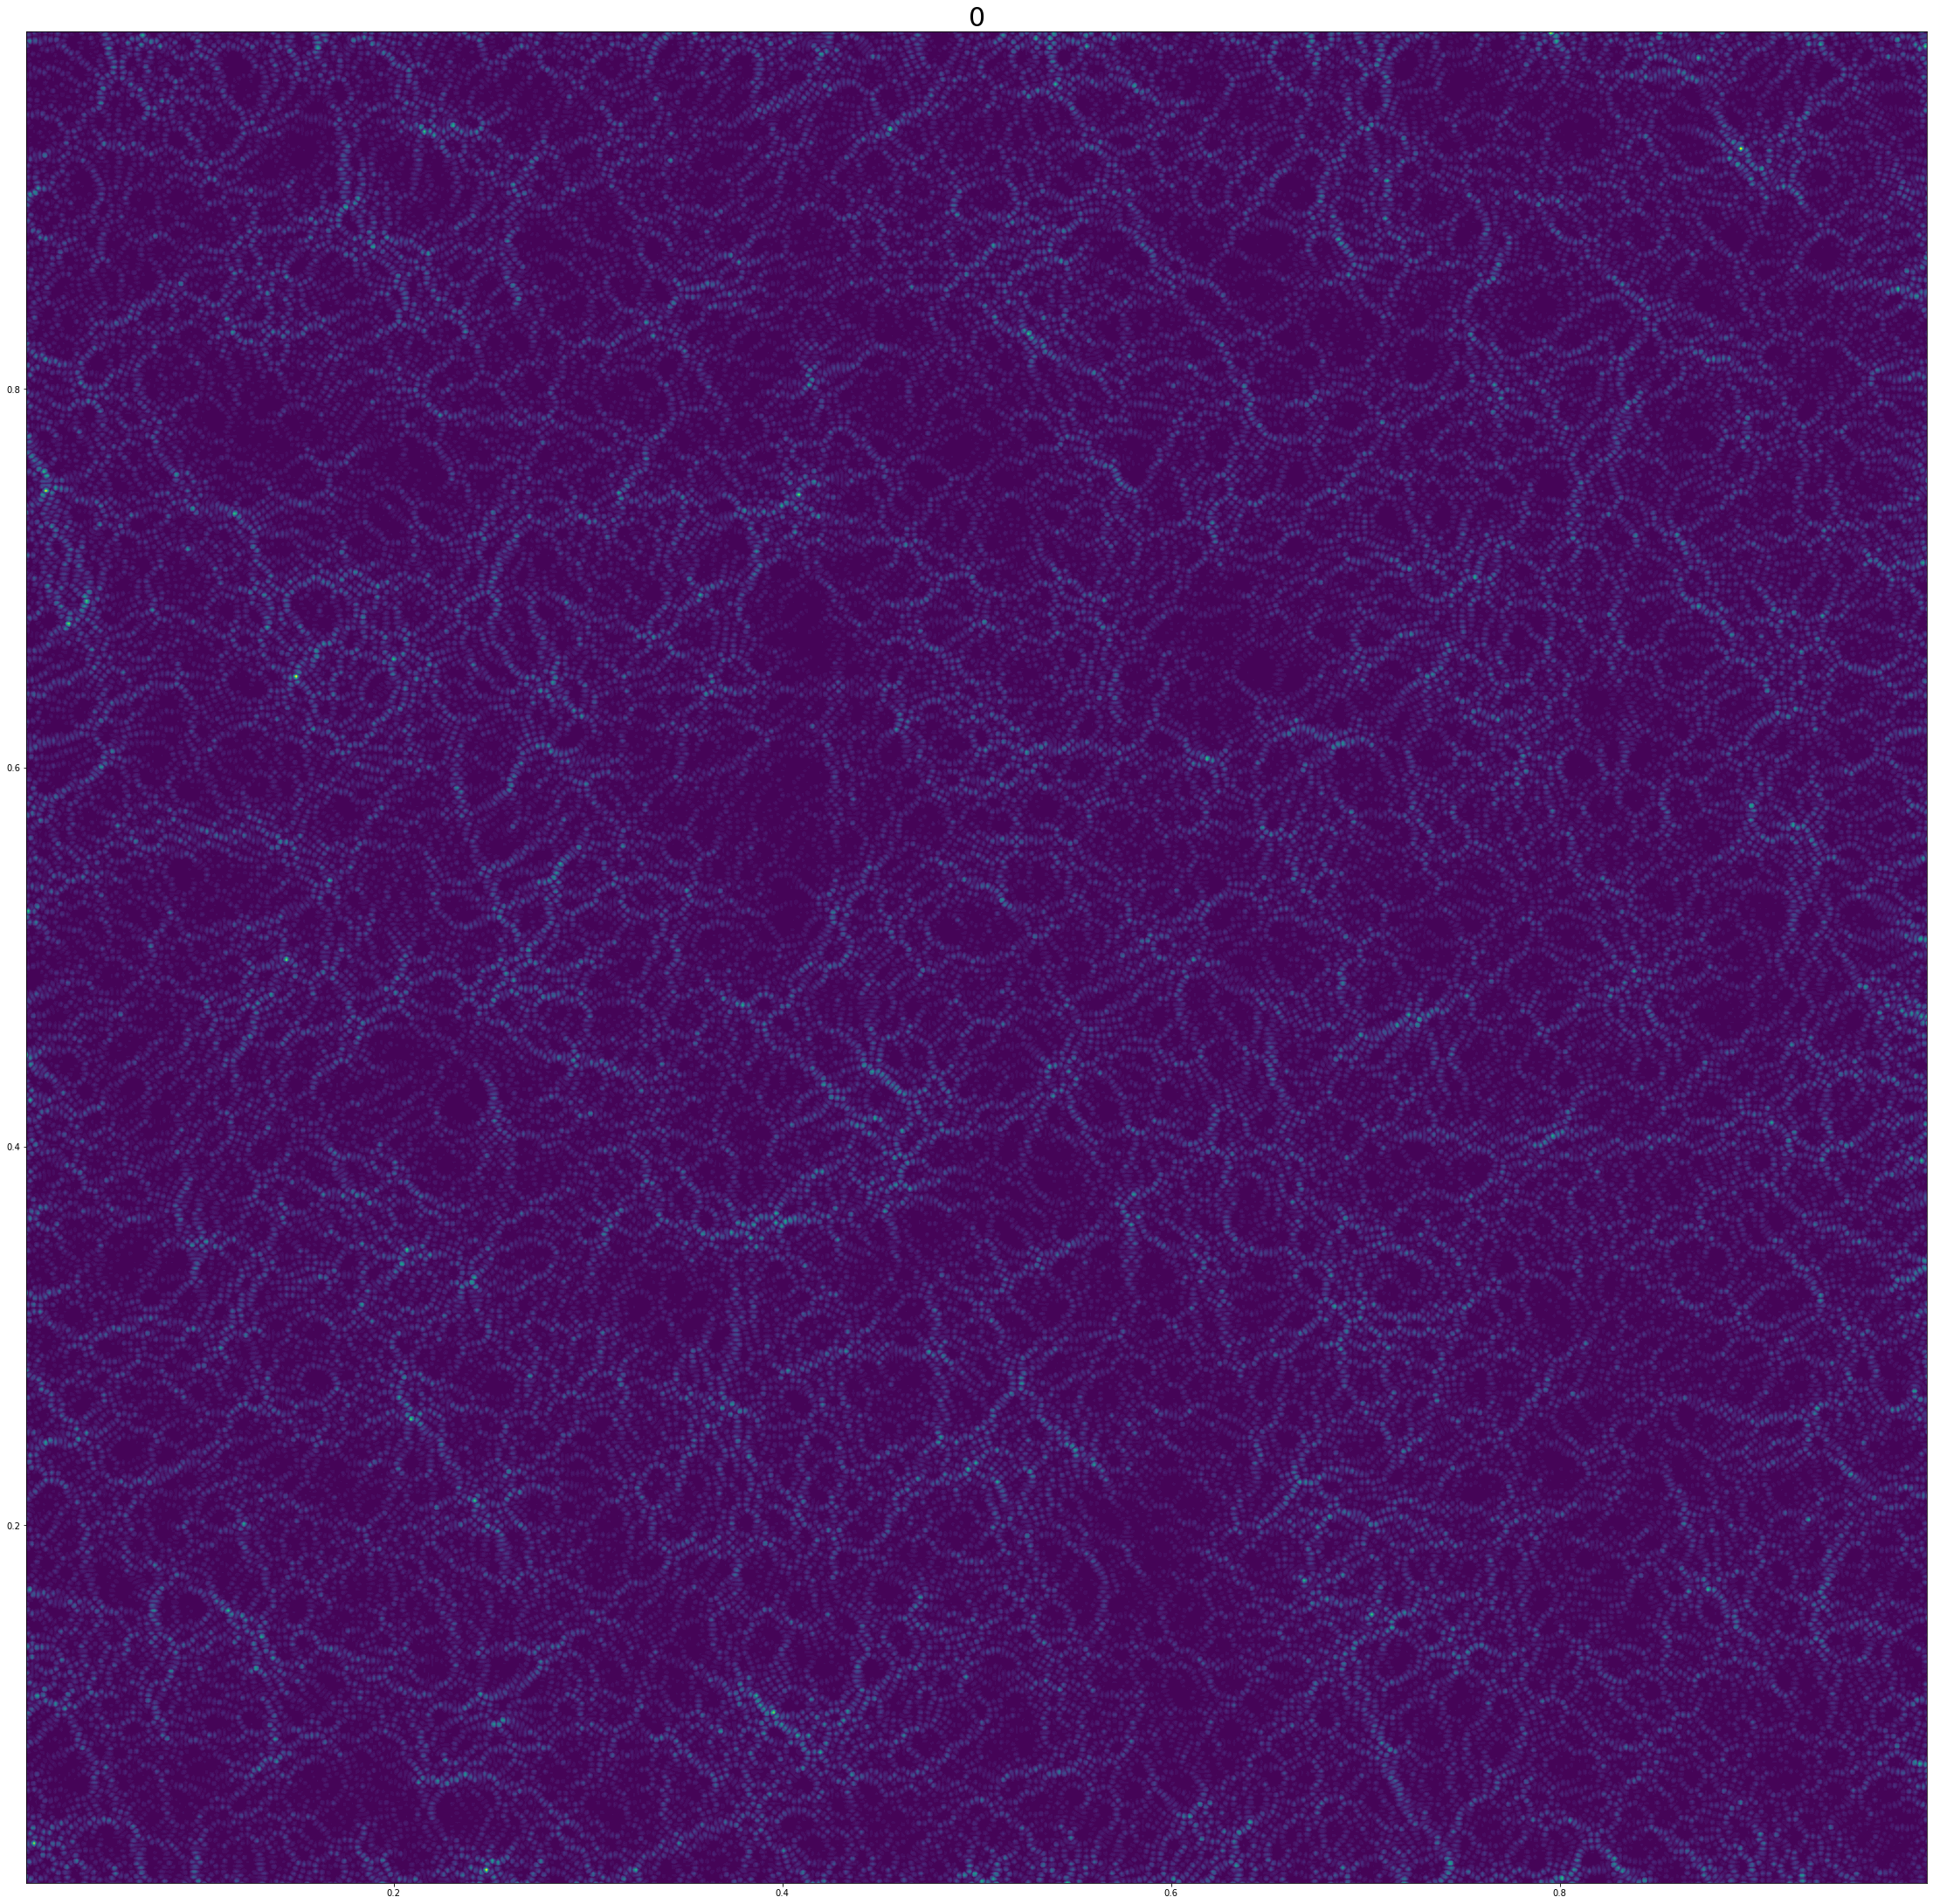

In [13]:

for j in range(11,12,2):
    #plt.plot(y,  get_e2(i))
    plt.figure(figsize=(39,39))
    plt.contourf(y[j:-j], x[j:-j], get(0,j)**2, 50)
    plt.title('{}'.format(0), fontsize=30)
    #plt.savefig('0势能2002vc万分之一倍始能量_{}.png'.format(j))
    #plt.grid()